In [1]:
#Model 6

import tensorflow 

#import keras
from tensorflow import keras
import keras.utils
import sys, os  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns


from keras.callbacks import ModelCheckpoint
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Activation, Flatten  
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D  
from keras.losses import categorical_crossentropy  
from tensorflow.keras.optimizers import Adam  
from keras.regularizers import l2  
from keras.utils import np_utils  

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

keras.backend.clear_session()
df=pd.read_csv('img_pixels.csv')  


In [2]:
import wandb
wandb.init(project="vision autocorrect", entity="jeetg57", name="Model 6R12")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jeetg57 (use `wandb login --relogin` to force relogin)


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


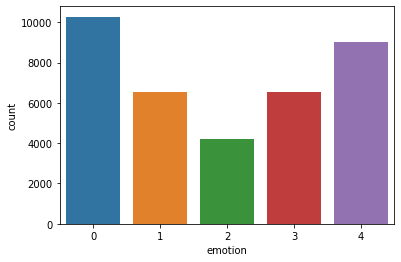

In [3]:
sns.countplot(df.emotion)
plt.show()

X_train,train_y,X_test,test_y=[],[],[],[]  
  
for index, row in df.iterrows():  
    val=row['pixels'].split(" ")  
    try:  
        if 'Training' in row['Usage']:  
           X_train.append(np.array(val,'float32'))  
           train_y.append(row['emotion'])  
        elif 'PublicTest' in row['Usage']:  
           X_test.append(np.array(val,'float32'))  
           test_y.append(row['emotion'])  
    except:  
        print(f"error occured at index :{index} and row:{row}")  

In [4]:
num_labels = 5 #changed to 0-4=5  
batch_size = 32
epochs = 50
width, height = 48, 48  
  
  
X_train = np.array(X_train,'float32')  
train_y = np.array(train_y,'float32')  
X_test = np.array(X_test,'float32')  
test_y = np.array(test_y,'float32')  
  
train_y=np_utils.to_categorical(train_y, num_classes=num_labels)  
test_y=np_utils.to_categorical(test_y, num_classes=num_labels)  


In [5]:
#cannot produce  
#normalizing data between 0 and 1  
X_train -= np.mean(X_train, axis=0)  
X_train /= np.std(X_train, axis=0)  
  
X_test -= np.mean(X_test, axis=0)  
X_test /= np.std(X_test, axis=0)  
  
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)  
  
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)  
  

##designing the cnn  
#1st convolution layer  
#model = keras.models.Sequential() 


In [6]:
from keras import layers

modelN = keras.models.Sequential()
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        input_shape=(48, 48, 1)))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
modelN.add(layers.MaxPooling2D(pool_size=(2, 2)))

modelN.add(layers.Flatten())  # this converts our 3D feature maps to 1D feature vectors
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(64, activation='relu'))
modelN.add(layers.Dense(5, activation='softmax'))

model=modelN
# optimizer:

opt=Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


classes=[0,1,2,3,4]
classes_labels=["None","Fatigue","Glare","Normal","squint"]

model.summary()

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)



In [ ]:
revname = "6R12"
modelname = "./NEW MODELS/Model 6/" + revname +  "/"
#tbCallBack = keras.callbacks.TensorBoard(log_dir="C:/Users/Prof. Leah Mutanu/source/repos/pylesson35/pylesson35", histogram_freq=2, write_graph=True, write_images=True)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5, restore_best_weights = True )

lr_scheduler = ReduceLROnPlateau(
	    monitor='val_accuracy',
	    factor=0.5,
	    patience=5,
	    min_lr=1e-7,
	    verbose=1,
	)

bestmodelname = modelname + "best_model.h5"
mc = ModelCheckpoint(bestmodelname, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

callbacks=[es, lr_scheduler, mc]

In [ ]:
#Training the model  
history=model.fit(train_datagen.flow(X_train, train_y, batch_size=batch_size),  
          batch_size=batch_size,  
          epochs=epochs,
          verbose=1,  
          callbacks=callbacks,
          validation_data=(X_test, test_y),  
          shuffle=True)  

In [ ]:
#create confusion matrix
y_true=np.argmax(test_y,axis=1)
y_pred=model.predict(X_test)

con_mat = tensorflow.math.confusion_matrix(labels=y_true, predictions=y_pred.argmax(axis=1)).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes_labels, 
                     columns = classes_labels)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
figure.savefig(modelname + "confusion_matrix.png")

#plot model accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(modelname + "model_accuracy.png")


#plot model loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(modelname + "model_loss.png")

scores = model.evaluate(X_train, train_y, verbose=1, batch_size=batch_size)
print('Model ' + revname + ' Accuracy: {}'.format(scores[1]))

In [ ]:
f = open("./NEW MODELS/Accuracies.txt", "a")
f.write("\n" + revname + ' : {}'.format(scores[1]))
f.close()

In [ ]:
#Saving the  model to  use it later on  
fer_json = model.to_json()  
with open(modelname + revname + ".json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights(modelname + revname + ".h5")


In [ ]:
!jupyter nbconvert 'Model 6.ipynb' --to html --output 'NEW MODELS/Model 6/6R12/model.html'